<a href="https://colab.research.google.com/github/bshazia/Apple_Stocks/blob/main/Apple_stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
!pip install yfinance==0.2.12

**Step 1: Data Collection**

In [221]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [222]:
#daily data for past 10 years
data_daily = yf.download("AAPL", period="10y", interval="1d")

#monthly data for past 10 years
data_monthly = yf.download("AAPL", period="10y", interval="1mo")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/yfinance/utils.py:517: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  quotes.loc[idx2, "High"] = _np.nanmax([quotes["High"][n - 1], quotes["High"][n - 2]])
/usr/local/lib/python3.10/dist-packages/yfinance/utils.py:518: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  quotes.loc[idx2, "Low"] = _np.nanmin([quotes["Low"][n - 1], quotes["Low"][n - 2]])
/usr/local/lib/python3.10/dist-packages/yfinance/utils.py:519: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame beha

In [223]:
data_daily.sample(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-09-11,180.070007,180.300003,177.339996,179.360001,178.653412,58953100
2021-11-12,148.429993,150.399994,147.479996,149.990005,147.906036,63804000
2020-05-19,78.757500,79.629997,78.252502,78.285004,76.454315,101729600
2021-11-22,161.679993,165.699997,161.000000,161.020004,158.782776,117467900
2016-07-28,25.707500,26.112499,25.705000,26.084999,23.958725,159479200


Step 2: Data Preprocessing

In [225]:
data_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2517 entries, 2014-08-08 to 2024-08-08
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2517 non-null   float64
 1   High       2517 non-null   float64
 2   Low        2517 non-null   float64
 3   Close      2517 non-null   float64
 4   Adj Close  2517 non-null   float64
 5   Volume     2517 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 137.6 KB


In [226]:
data_monthly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 120 entries, 2014-09-01 to 2024-08-01
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       120 non-null    float64
 1   High       120 non-null    float64
 2   Low        120 non-null    float64
 3   Close      120 non-null    float64
 4   Adj Close  120 non-null    float64
 5   Volume     120 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 6.6 KB


In [227]:
# Check for missing dates in daily data
all_dates_daily = pd.date_range(start=data_daily.index.min(), end=data_daily.index.max(), freq='D')
missing_dates_daily = all_dates_daily.difference(data_daily.index)
print("Missing dates in daily data:", missing_dates_daily)
print("Number of missing dates in daily data:", missing_dates_daily.size)

# Check for missing dates in monthly data
all_dates_monthly = pd.date_range(start=data_monthly.index.min(), end=data_monthly.index.max(), freq='M')
missing_dates_monthly = all_dates_monthly.difference(data_monthly.index)
print("Missing dates in monthly data:", missing_dates_monthly)
print("Number of missing dates in monthly data:", missing_dates_monthly.size)

Missing dates in daily data: DatetimeIndex(['2014-08-09', '2014-08-10', '2014-08-16', '2014-08-17',
               '2014-08-23', '2014-08-24', '2014-08-30', '2014-08-31',
               '2014-09-01', '2014-09-06',
               ...
               '2024-07-06', '2024-07-07', '2024-07-13', '2024-07-14',
               '2024-07-20', '2024-07-21', '2024-07-27', '2024-07-28',
               '2024-08-03', '2024-08-04'],
              dtype='datetime64[ns]', length=1137, freq=None)
Number of missing dates in daily data: 1137
Missing dates in monthly data: DatetimeIndex(['2014-09-30', '2014-10-31', '2014-11-30', '2014-12-31',
               '2015-01-31', '2015-02-28', '2015-03-31', '2015-04-30',
               '2015-05-31', '2015-06-30',
               ...
               '2023-10-31', '2023-11-30', '2023-12-31', '2024-01-31',
               '2024-02-29', '2024-03-31', '2024-04-30', '2024-05-31',
               '2024-06-30', '2024-07-31'],
              dtype='datetime64[ns]', length=119, freq

In [228]:
#lets verify it with market calendar
#     !pip install pandas_market_calendars
import pandas_market_calendars as mcal

nyse = mcal.get_calendar('NYSE')

trading_days = nyse.schedule(start_date=data_daily.index.min(), end_date=data_daily.index.max())

non_trading_days = missing_dates_daily[~missing_dates_daily.isin(trading_days.index)]

print("Number of missing dates that are non-trading days:", non_trading_days.size)

Number of missing dates that are non-trading days: 1137


these are non-trading days and it's not impacting our data


In [229]:
# Previous day's closing price
data_daily['Close_Lag1'] = data_daily['Close'].shift(1)

data_daily['Close_MA5'] = data_daily['Close'].rolling(window=5).mean()
data_daily['Close_MA20'] = data_daily['Close'].rolling(window=20).mean()

In [230]:
# Calculate 5-day SMA
data_daily['SMA_5_'] = data_daily['Close'].rolling(window=5).sum() / 5

In [231]:
data_daily['SMA_5_'].sample(10)

,SMA_5_
Date,
2023-08-30,181.389999
2024-04-16,172.288000
2016-07-21,24.893500
2016-12-16,28.773500
2015-05-12,31.504000
2021-06-23,132.445999
2020-10-07,114.910001
2019-01-22,38.699501
2018-08-20,53.317501


**Training**

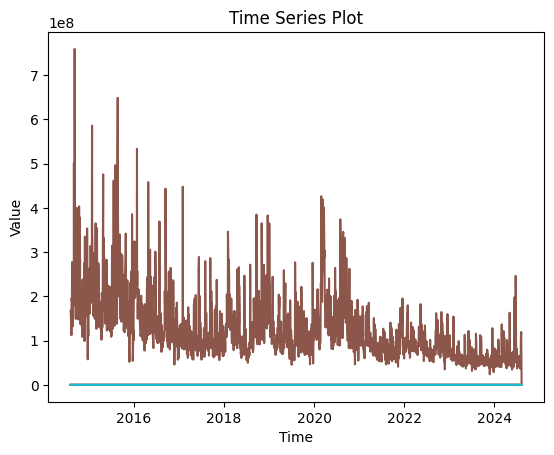

In [232]:
#checking for trend
import matplotlib.pyplot as plt

plt.plot(data_daily)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time Series Plot')
plt.show()

In [233]:
features = ['Close_Lag1', 'Close_MA5', 'Open',	'High'	,'Low']
x = data_daily[features]
y = data_daily['Close'][x.index]

In [234]:
# Handle missing values (due to lagged features)
x = x.dropna()
y = y[x.index]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)


In [235]:
X_train_lstm = X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_lstm = X_test.values.reshape(X_test.shape[0], 1, X_test.shape[1])


In [236]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, input_shape=(1, X_train.shape[1])))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [247]:
model_lstm.fit(X_train_lstm, y_train, epochs=50, batch_size=32)


Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10.7844
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 13.2624
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.4134
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.8679
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.6953
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.0499
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.5500
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.9327
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.0803
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.7602
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.0600
Epoch 12/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10.0271
Epoch 13/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10.0807
Epoch 14/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.3644
Epoch 15/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.7710
Epoch 16/50
63/

**Evaluation**

In [248]:
y_pred_lstm = model_lstm.predict(X_test_lstm)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [249]:
# Evaluate performance (flatten predictions for metrics)
mse_lstm = mean_squared_error(y_test, y_pred_lstm.flatten())
rmse_lstm = mean_squared_error(y_test, y_pred_lstm.flatten(), squared=False)
mae_lstm = mean_absolute_error(y_test, y_pred_lstm.flatten())

print("LSTM - MSE:", mse_lstm, "RMSE:", rmse_lstm, "MAE:", mae_lstm)

LSTM - MSE: 234.8089685418486 RMSE: 15.32347769084579 MAE: 10.343811247505203


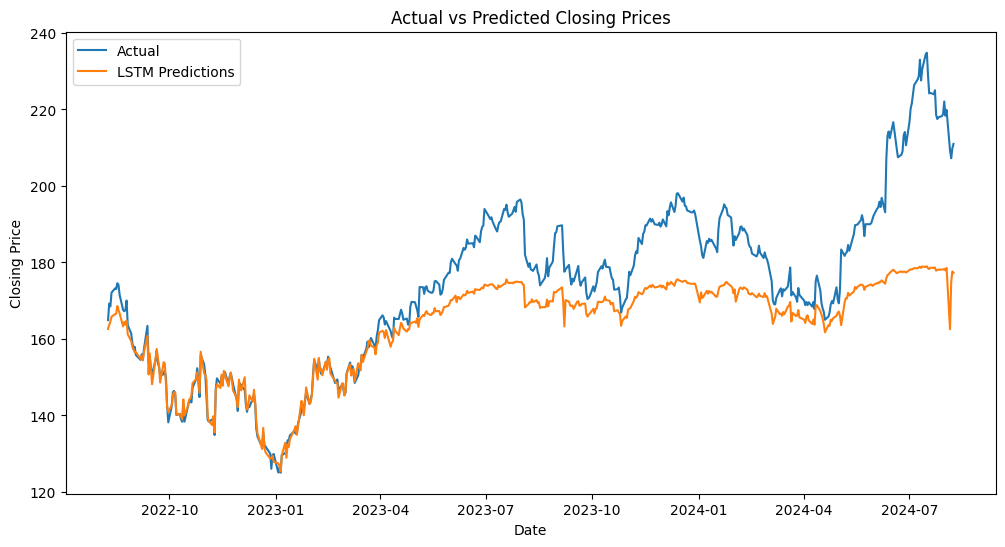

In [250]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred_lstm, label='LSTM Predictions')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Actual vs Predicted Closing Prices')
plt.legend()
plt.show()

cheking with prophit now

In [ ]:
df_train = pd.DataFrame({'ds': X_train.index, 'y': y_train})
df_test = pd.DataFrame({'ds': X_test.index, 'y': y_test})